### Census Income Project
Problem Statement:


This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

Description of fnlwgt (final weight)
The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

A single cell estimate of the population 16+ for each state.

Controls for Hispanic Origin by age and sex.

Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_excel('census.xlsx')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
display(df.head())

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [3]:
df.shape

(32560, 15)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      30717 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
df.describe()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
[i for i in df.columns if df[i].isnull().sum()>0]

['Occupation']

In [9]:
df['Income'].value_counts()

 <=50K    24719
 >50K     7841 
Name: Income, dtype: int64

<AxesSubplot:xlabel='Income', ylabel='count'>

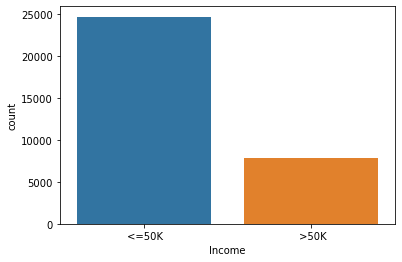

In [14]:
sns.countplot(df.Income)

Text(0.5, 1.0, 'Education')

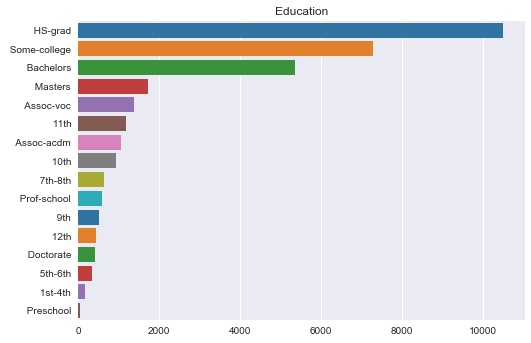

In [62]:
Education = df['Education'].value_counts()
sns.barplot(Education.values,Education.index,palette='tab10')
plt.title('Education')

Text(0.5, 1.0, 'Education_num')

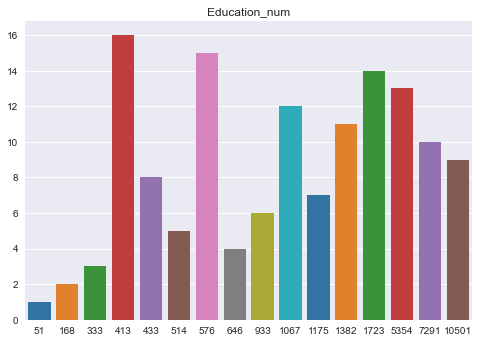

In [65]:
Education_num = df['Education_num'].value_counts(sort=True)
sns.barplot(Education_num.values,Education_num.index,palette='tab10')
plt.title('Education_num')

Text(0.5, 1.0, 'Marital_status')

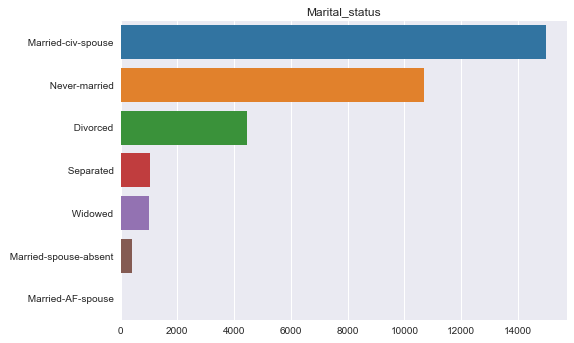

In [70]:
Marital_status = df['Marital_status'].value_counts(sort=True)
sns.barplot(Marital_status.values,Marital_status.index,palette='tab10')
plt.title('Marital_status')

Text(0.5, 1.0, 'Occupation')

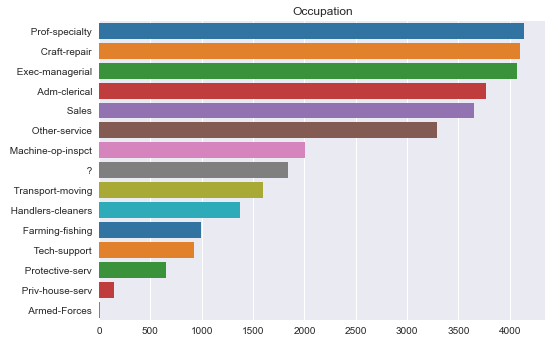

In [71]:
Occupation = df['Occupation'].value_counts(sort=True)
sns.barplot(Occupation.values,Occupation.index,palette='tab10')
plt.title('Occupation')

Text(0.5, 1.0, 'Relationship')

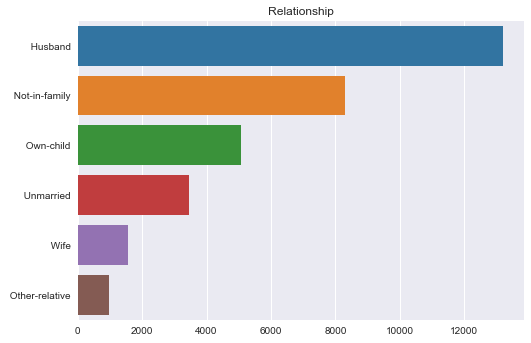

In [72]:
Relationship = df['Relationship'].value_counts(sort=True)
sns.barplot(Relationship.values,Relationship.index,palette='tab10')
plt.title('Relationship')

Text(0.5, 1.0, 'Race')

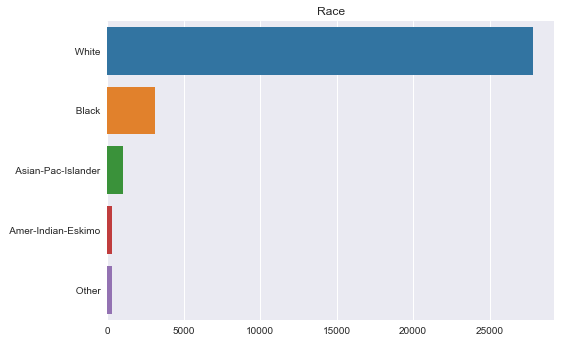

In [79]:
Race = df['Race'].value_counts(sort=True)
sns.barplot(Race.values,Race.index,palette='tab10')
plt.title('Race')

Text(0.5, 1.0, 'Race')

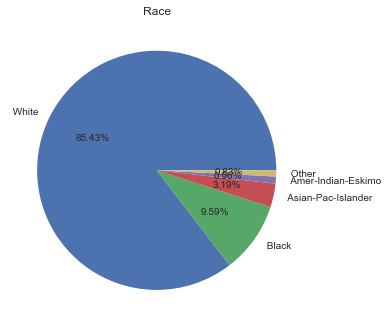

In [78]:
Race = df['Race'].value_counts(sort=True)
plt.pie(Race.values,labels=Race.index,autopct='%1.2f%%')
plt.title('Race')

Text(0.5, 1.0, 'Sex')

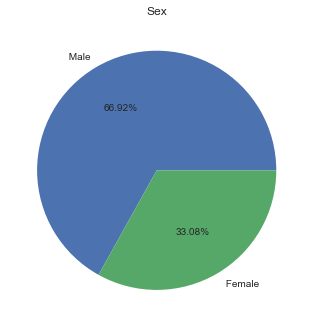

In [82]:
Sex = df['Sex'].value_counts(sort=True)
plt.pie(Sex.values,labels=Sex.index,autopct='%1.2f%%')
plt.title('Sex')

Text(0.5, 1.0, 'Hours_per_week')

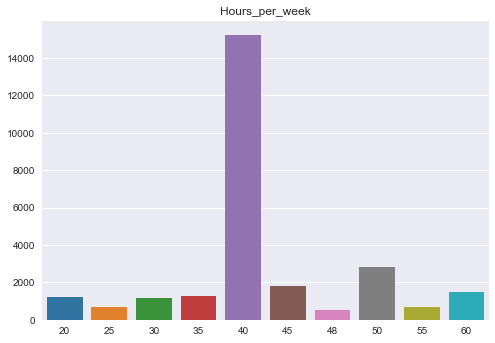

In [85]:
Hours_per_week = df['Hours_per_week'].value_counts(sort=True).head(10)
sns.barplot(Hours_per_week.index,Hours_per_week.values,palette='tab10')
plt.title('Hours_per_week')

Text(0.5, 1.0, 'Age vs Income')

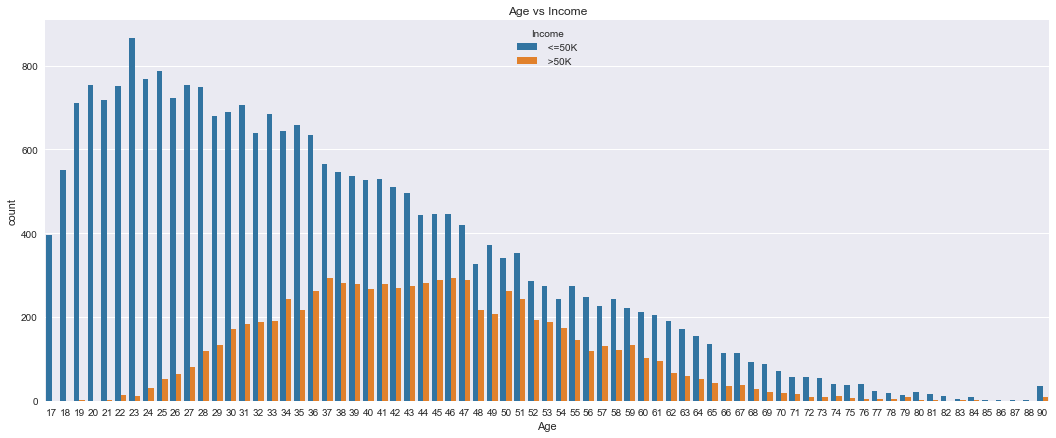

In [90]:
plt.figure(figsize=(18, 7))
sns.countplot(df['Age'], hue=df['Income'],palette='tab10')
plt.title('Age vs Income')

Text(0.5, 1.0, 'Workclass vs Income')

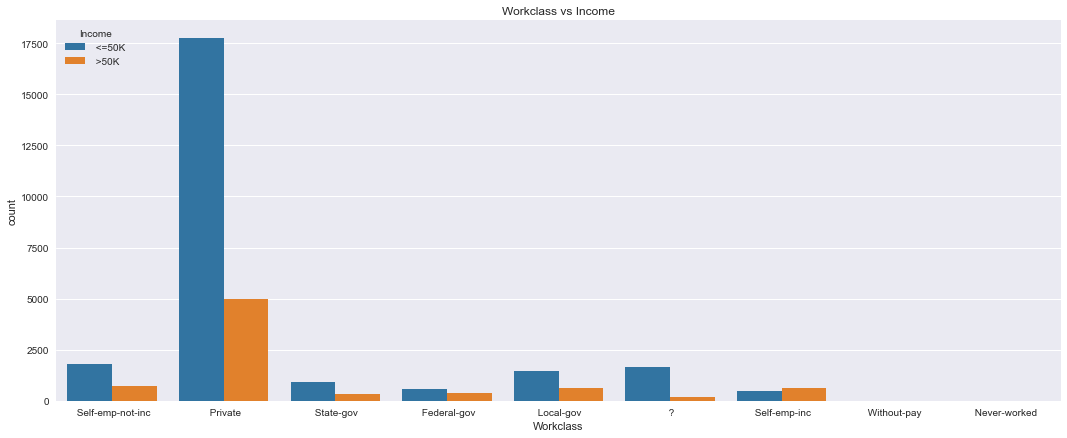

In [98]:
plt.figure(figsize=(18, 7))
sns.countplot(x = df['Workclass'], hue=df['Income'],palette='tab10')
plt.title('Workclass vs Income')

Text(0.5, 1.0, 'Education vs Income')

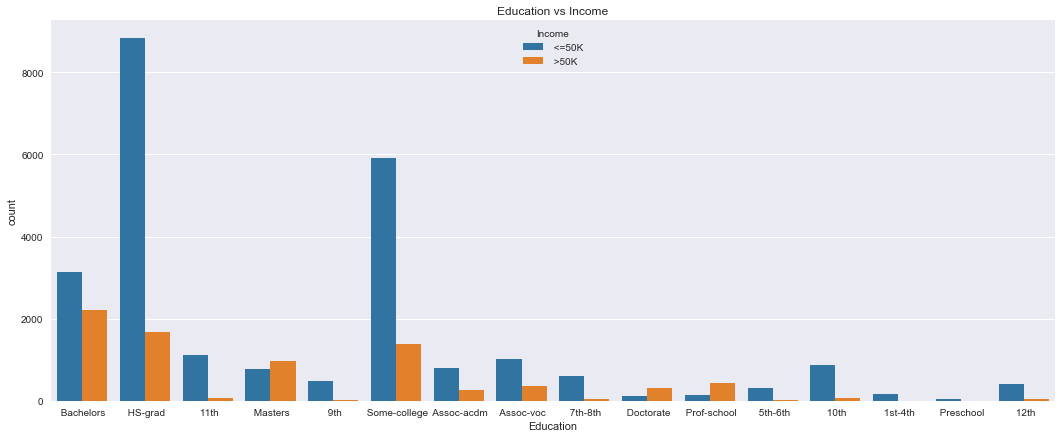

In [99]:
plt.figure(figsize=(18, 7))
sns.countplot(x = df['Education'], hue=df['Income'],palette='tab10')
plt.title('Education vs Income')

Text(0.5, 1.0, 'Education_num vs Income')

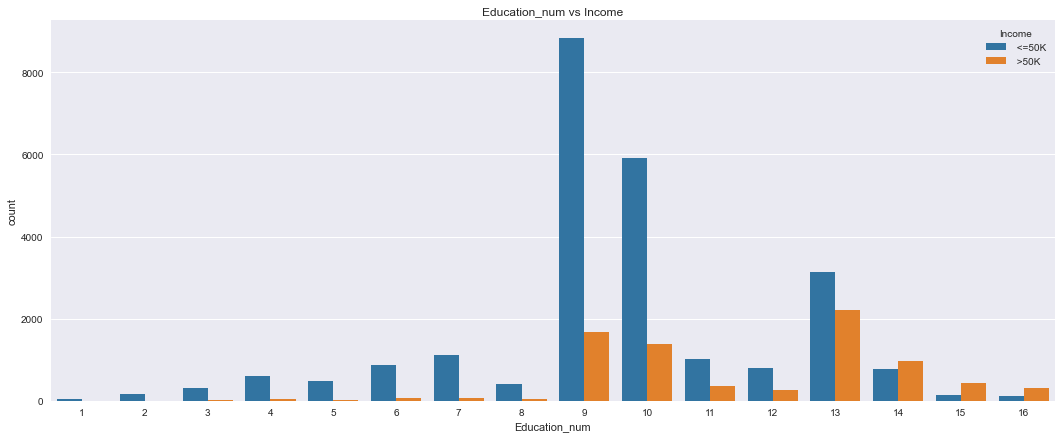

In [100]:
plt.figure(figsize=(18, 7))
sns.countplot(x = df['Education_num'], hue=df['Income'],palette='tab10')
plt.title('Education_num vs Income')

Text(0.5, 1.0, 'Marital_status vs Income')

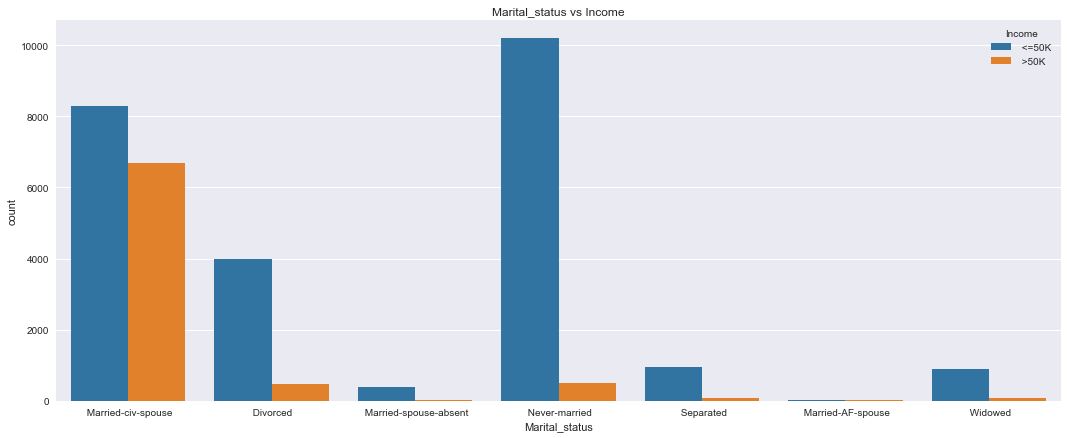

In [101]:
plt.figure(figsize=(18, 7))
sns.countplot(x = df['Marital_status'], hue=df['Income'],palette='tab10')
plt.title('Marital_status vs Income')

Text(0.5, 1.0, 'Occupation vs Income')

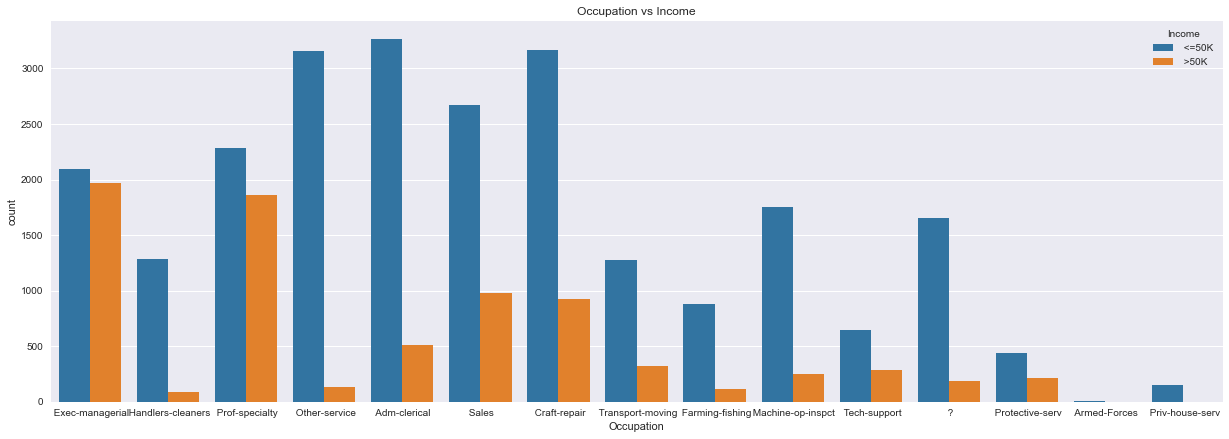

In [103]:
plt.figure(figsize=(21, 7))
sns.countplot(x = df['Occupation'], hue=df['Income'],palette='tab10')
plt.title('Occupation vs Income')

Text(0.5, 1.0, 'Relationship vs Income')

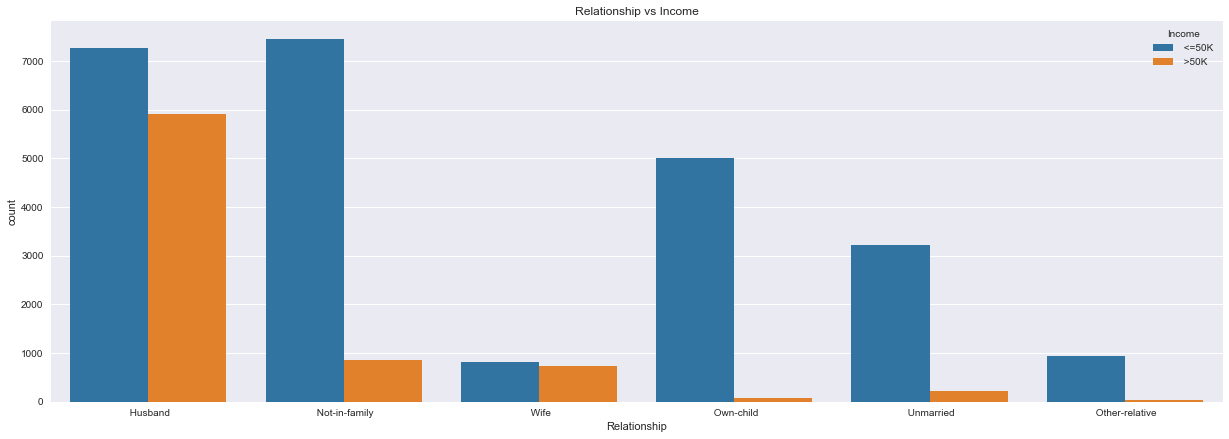

In [104]:
plt.figure(figsize=(21, 7))
sns.countplot(x = df['Relationship'], hue=df['Income'],palette='tab10')
plt.title('Relationship vs Income')

Text(0.5, 1.0, 'Race vs Income')

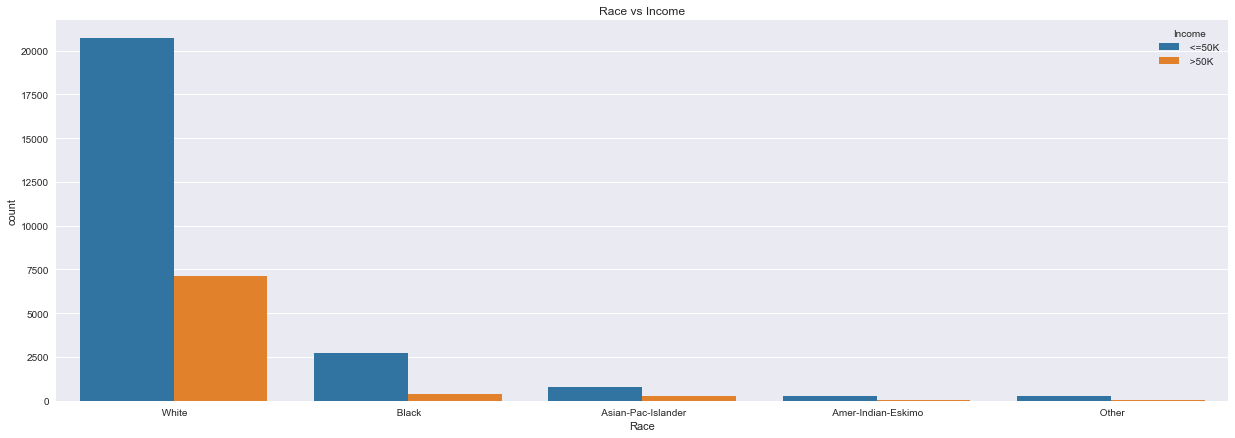

In [105]:
plt.figure(figsize=(21, 7))
sns.countplot(x = df['Race'], hue=df['Income'],palette='tab10')
plt.title('Race vs Income')

Text(0.5, 1.0, 'Sex vs Income')

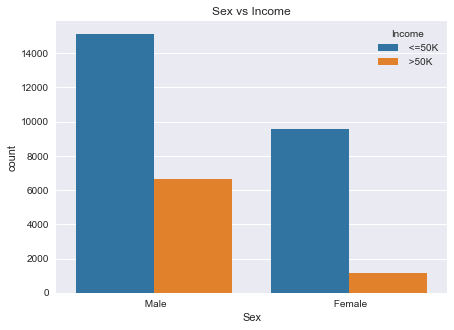

In [110]:
plt.figure(figsize=(7, 5))
sns.countplot(x = df['Sex'], hue=df['Income'],palette='tab10')
plt.title('Sex vs Income')

Text(0.5, 1.0, 'Hours_per_week vs Income')

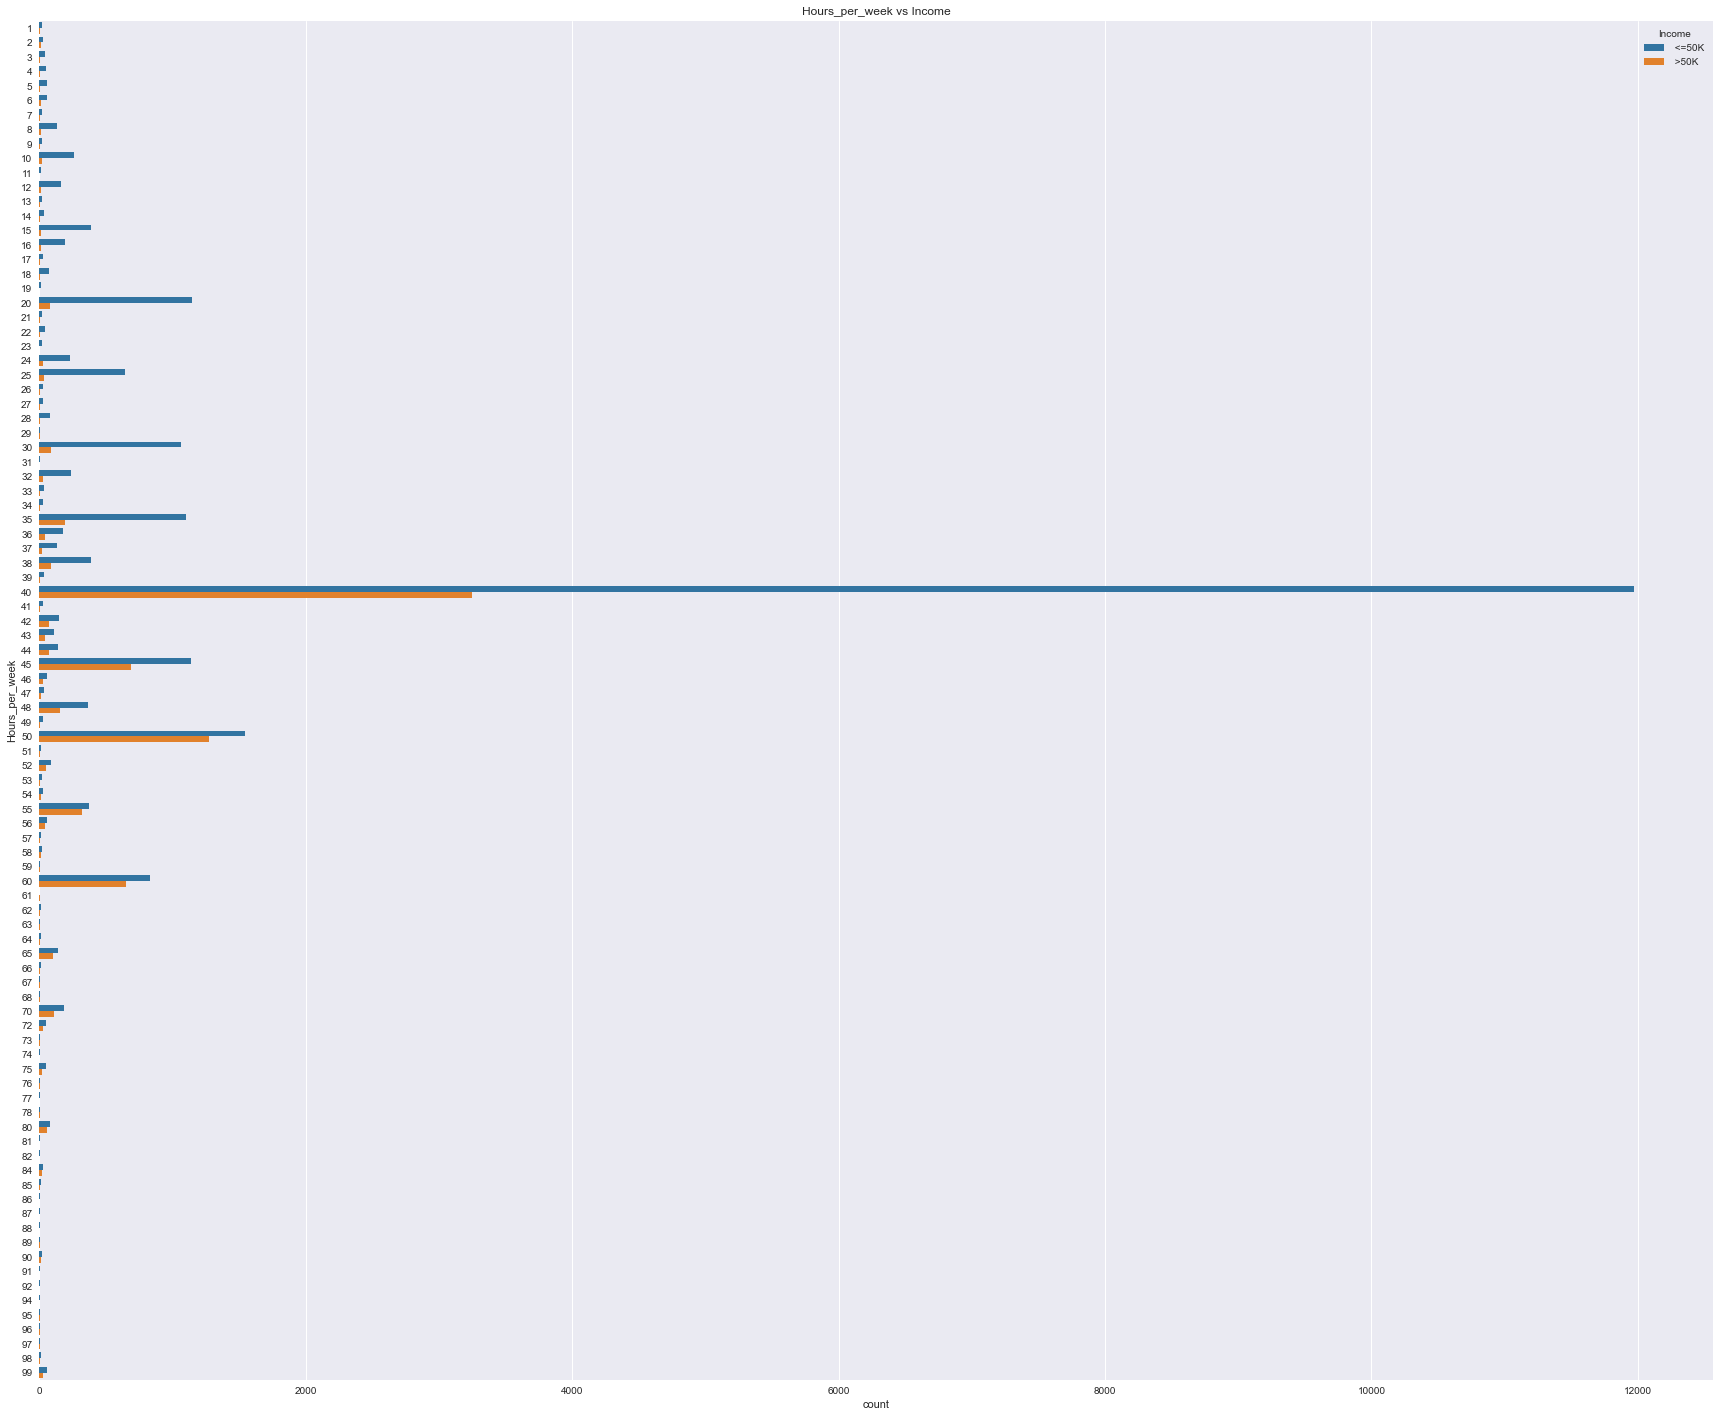

In [122]:
plt.figure(figsize=(30, 25))
sns.countplot(y = df['Hours_per_week'], hue=df['Income'],palette='tab10')
plt.title('Hours_per_week vs Income')

Text(0.5, 1.0, 'Native_country vs Income')

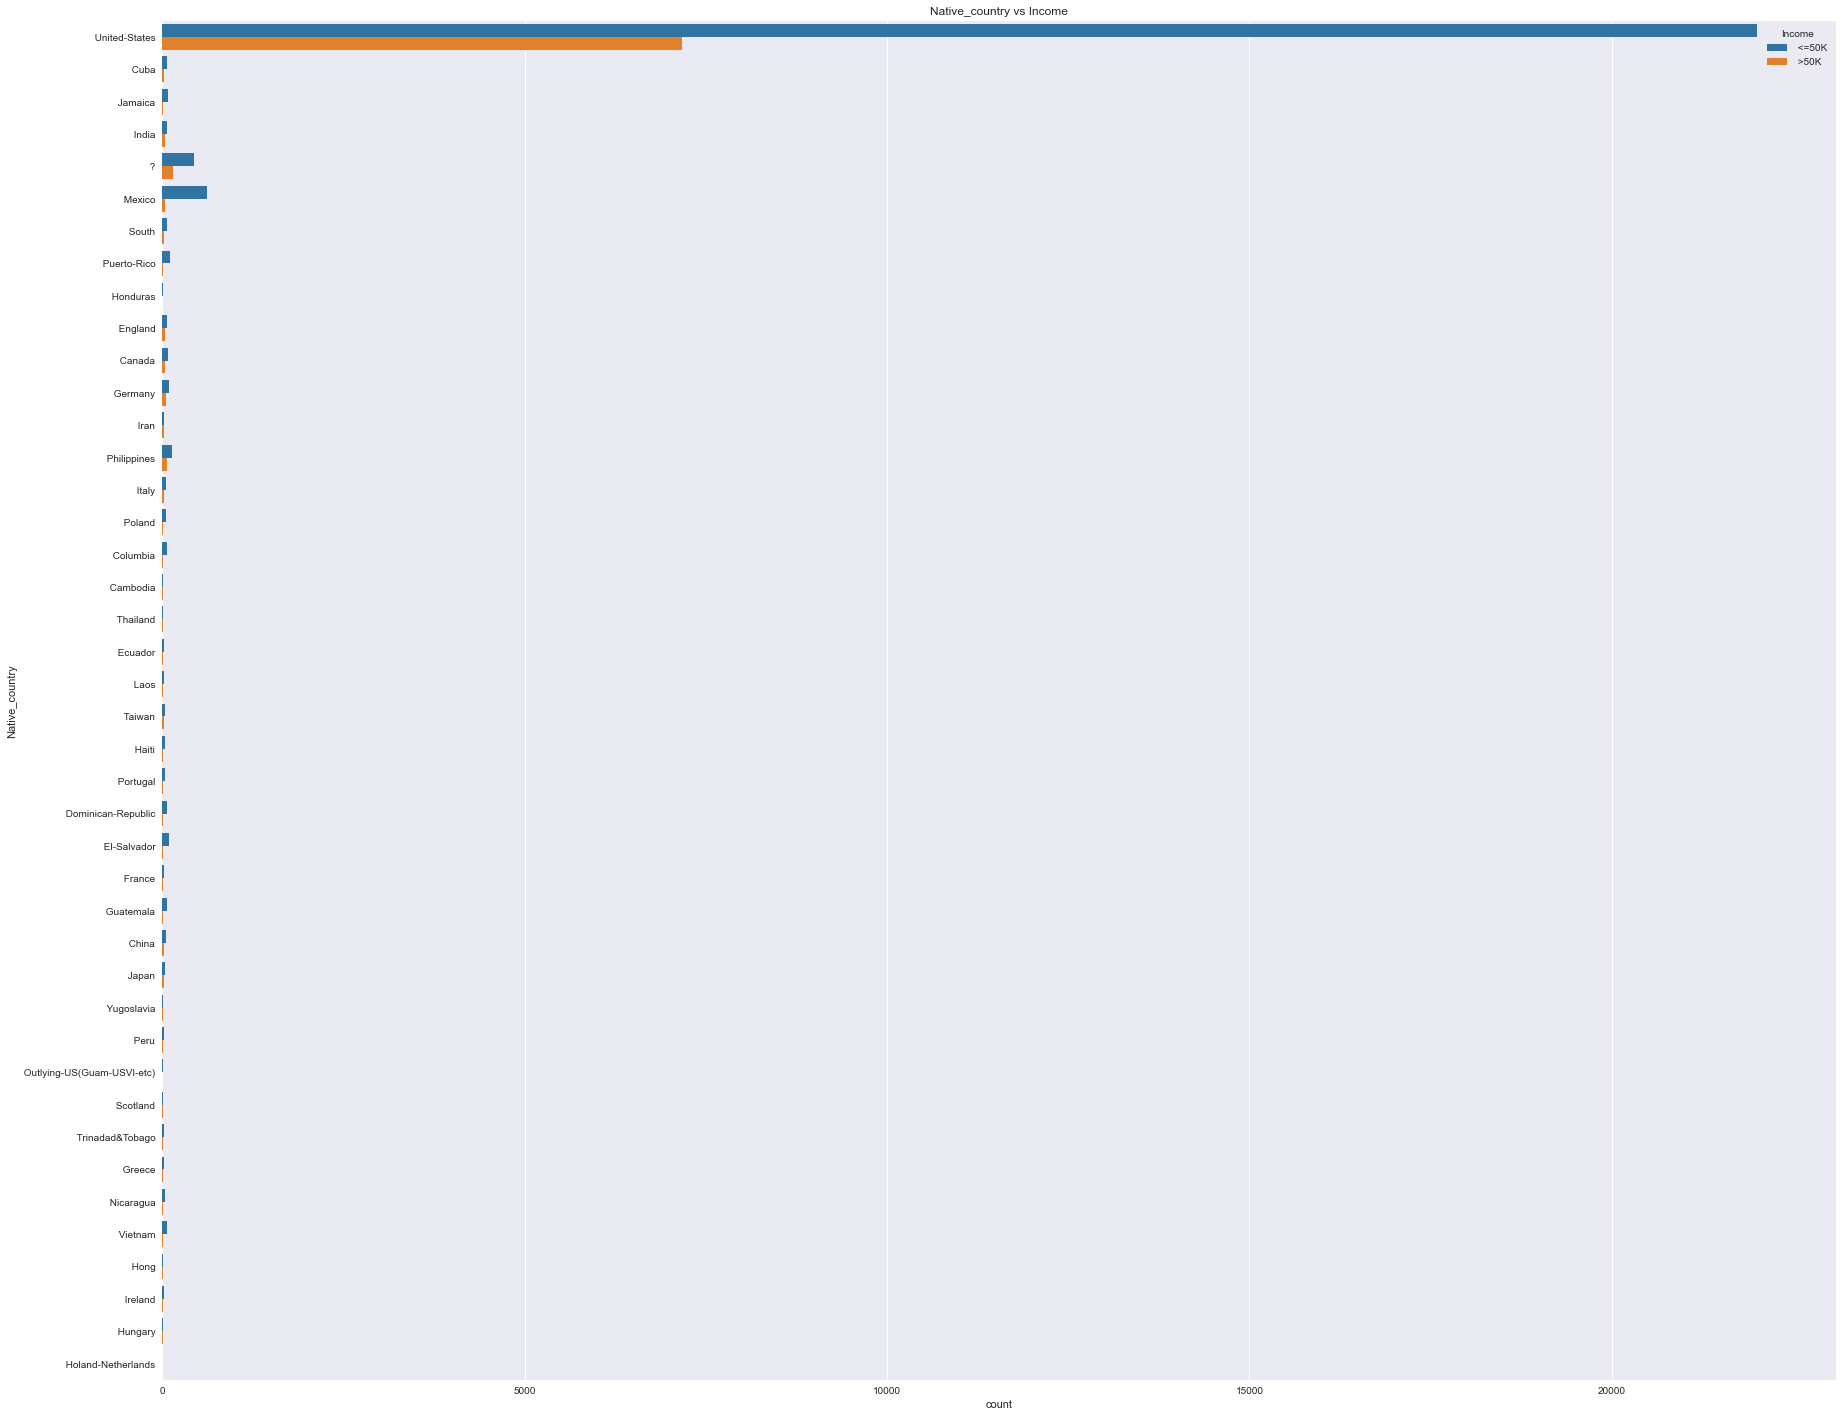

In [124]:
plt.figure(figsize=(30, 25))
sns.countplot(y = df['Native_country'], hue=df['Income'],palette='tab10')
plt.title('Native_country vs Income')

In [15]:
df.columns

Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_num',
       'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_gain', 'Capital_loss', 'Hours_per_week', 'Native_country',
       'Income'],
      dtype='object')

In [139]:
df.corr()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week,Income
Age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756,0.234039
Fnlwgt,-0.076646,1.000000,-0.043159,0.000437,-0.010259,-0.018770,-0.009481
Education_num,0.036527,-0.043159,1.000000,0.122627,0.079932,0.148127,0.335182
Capital_gain,0.077674,0.000437,0.122627,1.000000,-0.031614,0.078409,0.223333
Capital_loss,0.057775,-0.010259,0.079932,-0.031614,1.000000,0.054256,0.150523
Hours_per_week,0.068756,-0.018770,0.148127,0.078409,0.054256,1.000000,0.229690
Income,0.234039,-0.009481,0.335182,0.223333,0.150523,0.229690,1.000000


<AxesSubplot:>

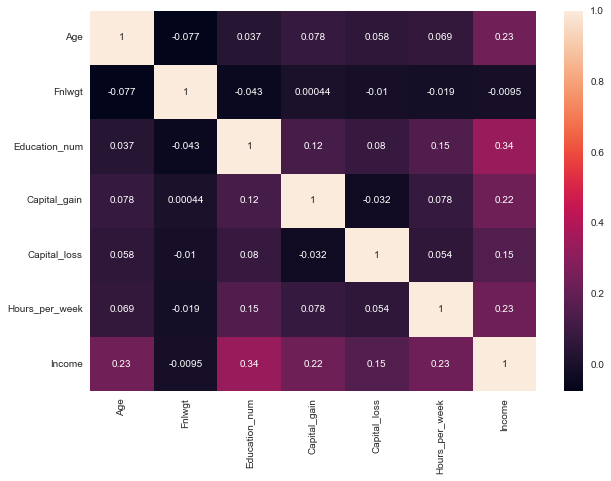

In [143]:
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(),annot=True)

In [12]:
df['Occupation'].mode()

0     Prof-specialty
dtype: object

In [13]:
df['Occupation'].fillna(df['Occupation'].mode()[0], inplace=True)

In [14]:
df.select_dtypes(exclude=['int64']).columns

Index(['Workclass', 'Education', 'Marital_status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Native_country', 'Income'],
      dtype='object')

In [15]:
category = ['Workclass', 'Education', 'Marital_status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Native_country', 'Income']
lab = LabelEncoder()
for i in category:
    df[i] = lab.fit_transform(df[i])

print(df.dtypes)

Age               int64
Workclass         int32
Fnlwgt            int64
Education         int32
Education_num     int64
Marital_status    int32
Occupation        int32
Relationship      int32
Race              int32
Sex               int32
Capital_gain      int64
Capital_loss      int64
Hours_per_week    int64
Native_country    int32
Income            int32
dtype: object


In [16]:
X = df.drop(['Income'],axis=1)
y = df['Income']

In [17]:
from sklearn.preprocessing import StandardScaler

In [19]:
for i in X.columns:
    scaler = StandardScaler()
    X[i] = scaler.fit_transform(X[i].values.reshape(-1, 1))

In [20]:
from imblearn.over_sampling import RandomOverSampler
ROS = RandomOverSampler(random_state=42)

In [21]:
ROS.fit(X,y)

RandomOverSampler(random_state=42)

In [22]:
X_ros, Y_ros= ROS.fit_resample(X, y)

In [24]:
Y_ros.value_counts(normalize=True)

0    0.5
1    0.5
Name: Income, dtype: float64

In [25]:
reg_model = [LinearRegression(),GradientBoostingRegressor(),AdaBoostRegressor(),DecisionTreeRegressor(),KNeighborsRegressor(),ExtraTreesRegressor(),RandomForestRegressor()]
max_r2_score = 0
for r_state in range(42,95):
    X_train, X_test, y_train, y_test = train_test_split(X_ros, Y_ros,random_state = r_state,test_size = 0.33)
    for i in reg_model:
        i.fit(X_train,y_train)
        pred = i.predict(X_test)
        r2_scores = r2_score(y_test,pred)
        print("R2 score for the random state is" ,r_state ,"is", r2_scores)
        if r2_scores > max_r2_score:
            max_r2_score = r2_scores
            final_state = r_state
            final_model = i
print()
print()
print()
print()
print("Maximum R2 score in the random state " ,final_state , "is" , max_r2_score ,"and model is",final_model)

R2 score for the random state is 42 is 0.31940814339100343
R2 score for the random state is 42 is 0.5417190879934902
R2 score for the random state is 42 is 0.38770552193012453
R2 score for the random state is 42 is 0.6300334764129601
R2 score for the random state is 42 is 0.5043086034537592
R2 score for the random state is 42 is 0.786159349366691
R2 score for the random state is 42 is 0.7587816304826027
R2 score for the random state is 43 is 0.3154845547730045
R2 score for the random state is 43 is 0.5277889082819043
R2 score for the random state is 43 is 0.36022715861248067
R2 score for the random state is 43 is 0.5927672068503168
R2 score for the random state is 43 is 0.5057797324315887
R2 score for the random state is 43 is 0.7814703756835848
R2 score for the random state is 43 is 0.7498842871602723
R2 score for the random state is 44 is 0.324981759100074
R2 score for the random state is 44 is 0.5392534821933498
R2 score for the random state is 44 is 0.4024124813528267
R2 score for 

In [26]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt','log2']
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
min_samples_split = [2, 5, 10,14]
min_samples_leaf = [1, 2, 4,6,8]

In [27]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              }
print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8]}


In [28]:
ETR=ExtraTreesRegressor()
RandomizedSearch_ETR=RandomizedSearchCV(estimator=ETR,param_distributions=param_grid,n_iter=100,cv=3,verbose=2,
                               random_state=57,n_jobs=-1)
RandomizedSearch_ETR.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=ExtraTreesRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=57, verbose=2)

In [29]:
RandomizedSearch_ETR.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 120}

In [30]:
RandomizedSearch_ETR.best_estimator_

ExtraTreesRegressor(max_depth=120, max_features='sqrt', n_estimators=600)

In [31]:
ETR = ExtraTreesRegressor(n_estimators=600,min_samples_split=2,min_samples_leaf=1,max_features='sqrt',max_depth=340,random_state=57)
ETR.fit(X_train,y_train)
pred = ETR.predict(X_test)
r2_scores = r2_score(y_test,pred)
print("R2 Score :",r2_scores*100)

R2 Score : 78.3430866591335


In [32]:
print('Mean Absolute Error: ', mean_absolute_error(y_test,pred))
print('Mean squared Error: ', mean_squared_error(y_test,pred))
print('Root Mean Absolute Error: ', np.sqrt(mean_absolute_error(y_test,pred)))

Mean Absolute Error:  0.10550468212619607
Mean squared Error:  0.05414222456801474
Root Mean Absolute Error:  0.3248148428354161


Text(0, 0.5, 'Predicted_Y')

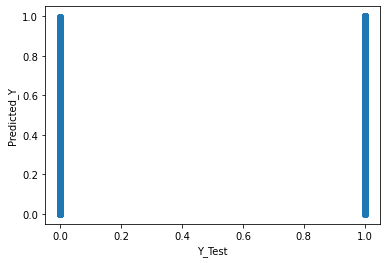

In [33]:
plt.scatter(x=y_test,y=pred)
plt.xlabel('Y_Test')
plt.ylabel('Predicted_Y')

In [34]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier

In [35]:
classification_model = [DecisionTreeClassifier(),KNeighborsClassifier()]
max_accuracy_score = 0
for r_state in range(40,90):
    X_train, X_test, y_train, y_test = train_test_split(X_ros, Y_ros,random_state = r_state,test_size = 0.33)
    for j in classification_model:
        j.fit(X_train,y_train)
        pred_c = j.predict(X_test)
        ac_score = accuracy_score(y_test,pred_c)
        print("accuracy score correspond to random state " ,r_state ,"is", ac_score)
        if ac_score> max_accuracy_score:
            max_accuracy_score=ac_score
            final_state = r_state
            final_model_classification = j
            
print()
print()
print()
print()

print("max accuracy score correspond to random state " ,final_state , "is" , max_accuracy_score ,"and model is",final_model_classification)

accuracy score correspond to random state  40 is 0.9016242721422004
accuracy score correspond to random state  40 is 0.8280723260802942
accuracy score correspond to random state  41 is 0.9086117070180815
accuracy score correspond to random state  41 is 0.8324241495556236
accuracy score correspond to random state  42 is 0.9085504137296966
accuracy score correspond to random state  42 is 0.8283174992338339
accuracy score correspond to random state  43 is 0.8994790070487282
accuracy score correspond to random state  43 is 0.8266012871590561
accuracy score correspond to random state  44 is 0.9034630707937481
accuracy score correspond to random state  44 is 0.8352436408213301
accuracy score correspond to random state  45 is 0.8978853815507202
accuracy score correspond to random state  45 is 0.8260496475635918
accuracy score correspond to random state  46 is 0.9030953110634385
accuracy score correspond to random state  46 is 0.8259883542752069
accuracy score correspond to random state  47 is

In [36]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [40]:
dec = DecisionTreeClassifier(random_state=69)
grid_search = GridSearchCV(estimator=dec, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [41]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=69), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [42]:
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5,
                       random_state=69)

In [43]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5}

In [44]:
DTC = DecisionTreeClassifier(criterion='entropy',max_depth=20, min_samples_leaf=5, random_state=69)
DTC.fit(X_train,y_train)
predc = DTC.predict(X_test)
acurracy_score = accuracy_score(y_test,predc)
print("Accuracy Score :",acurracy_score*100)

Accuracy Score : 84.11890897946674


In [46]:
pred_prob = DTC.predict_proba(X_test)[:,1]

In [47]:
fpr,tpr,thresholds = roc_curve(y_test,pred_prob,pos_label=True)

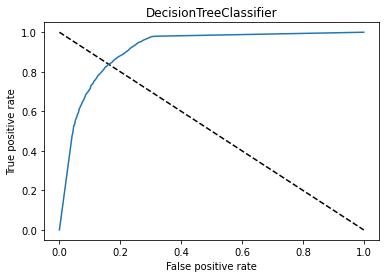

In [48]:
plt.plot([0,1],[1,0],'k--')
plt.plot(fpr,tpr,label = 'DecisionTreeClassifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('DecisionTreeClassifier')
plt.show()

In [49]:
confusion_matrix(y_test, predc)

array([[6561, 1580],
       [1011, 7163]], dtype=int64)

[Text(0.6828565907930376, 0.9761904761904762, 'X[5] <= -0.074\nentropy = 1.0\nsamples = 33123\nvalue = [16578, 16545]'),
 Text(0.45384312315450026, 0.9285714285714286, 'X[4] <= 0.94\nentropy = 0.935\nsamples = 23311\nvalue = [8186, 15125]'),
 Text(0.2343937758786244, 0.8809523809523809, 'X[5] <= -1.402\nentropy = 0.997\nsamples = 14795\nvalue = [6934, 7861]'),
 Text(0.07024971138048933, 0.8333333333333334, 'X[10] <= 0.893\nentropy = 0.663\nsamples = 2656\nvalue = [2198, 458]'),
 Text(0.04593213001198881, 0.7857142857142857, 'X[12] <= 0.248\nentropy = 0.573\nsamples = 2541\nvalue = [2196, 345]'),
 Text(0.010567914391012833, 0.7380952380952381, 'X[0] <= -0.519\nentropy = 0.421\nsamples = 1850\nvalue = [1692, 158]'),
 Text(0.003552240131432885, 0.6904761904761905, 'X[2] <= 1.732\nentropy = 0.106\nsamples = 285\nvalue = [281, 4]'),
 Text(0.002131344078859731, 0.6428571428571429, 'X[2] <= -1.266\nentropy = 0.036\nsamples = 266\nvalue = [265, 1]'),
 Text(0.001420896052573154, 0.5952380952380

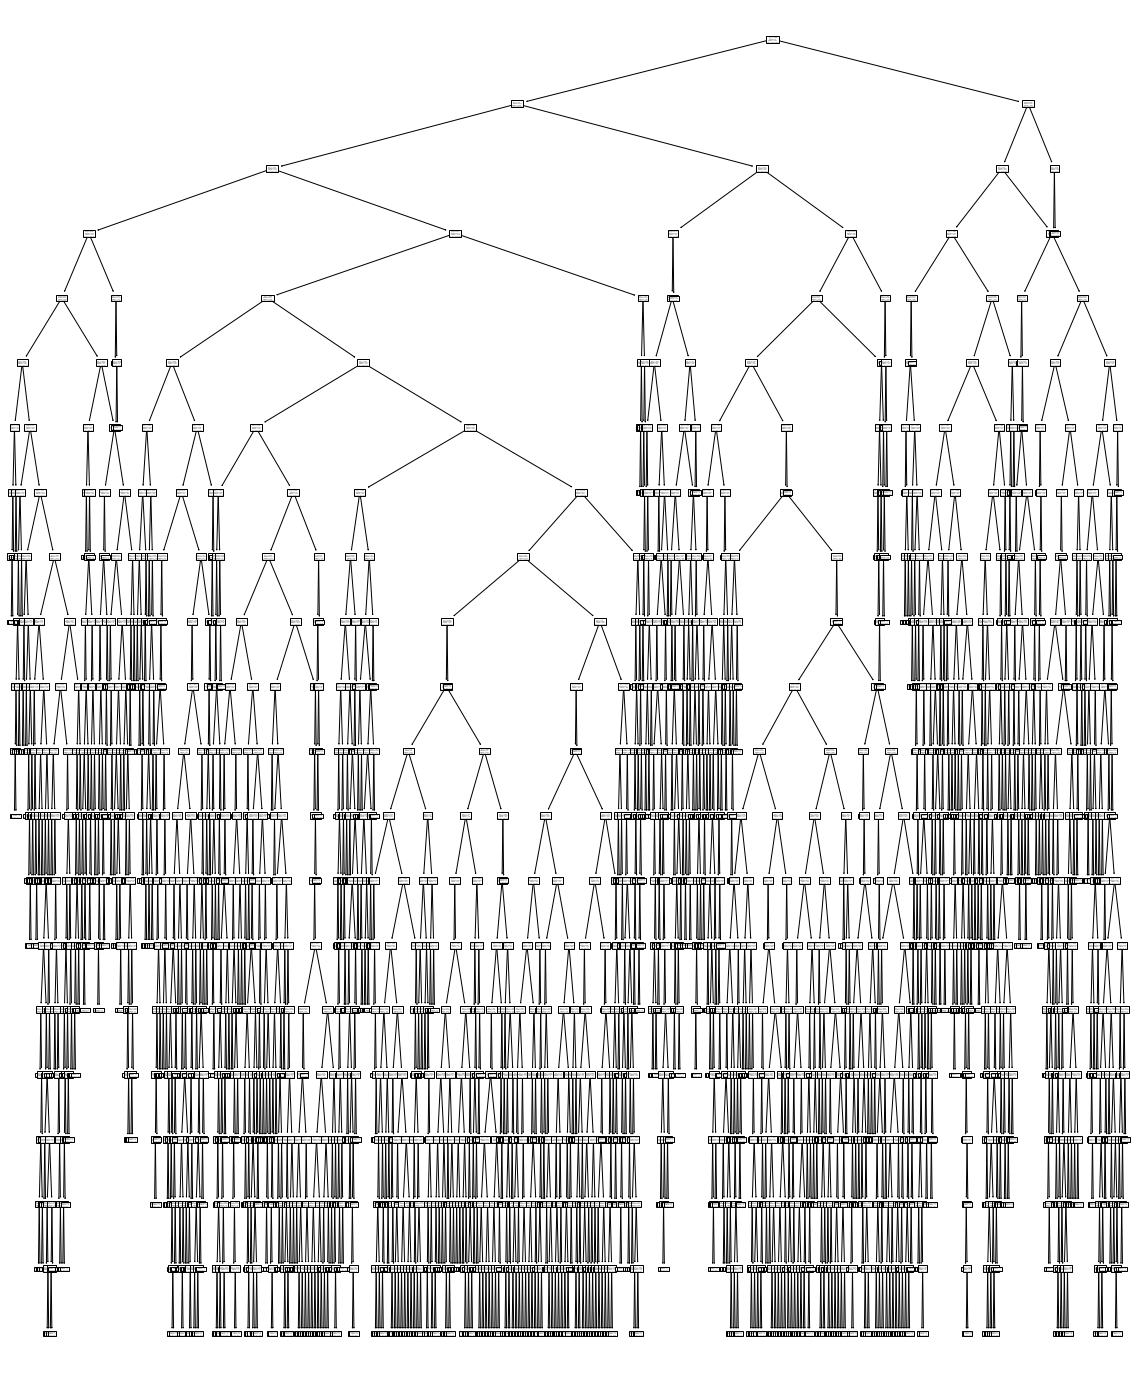

In [50]:
from sklearn import tree
g = plt.figure()
g.set_figwidth(20)
g.set_figheight(25)
tree.plot_tree(DTC)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, Y_ros, test_size = 0.3, random_state = 12345)

In [52]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34606, 14), (14832, 14), (34606,), (14832,))

In [53]:
log_reg = LogisticRegression(max_iter = 5000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [54]:
from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, log_reg.predict(X_test))
accuracy

0.7649002157497303

In [55]:
from sklearn.model_selection import RepeatedStratifiedKFold
X_train, X_test, y_train, y_test = train_test_split(X_ros, Y_ros, test_size = 0.3, random_state = 12345)
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [56]:
grid_result.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

In [57]:
grid_result.best_estimator_

LogisticRegression(C=0.01, solver='liblinear')

In [58]:
LR = LogisticRegression(C= 0.01, penalty= 'l2', solver= 'liblinear')
LR.fit(X_train,y_train)
predc = LR.predict(X_test)
acurracy_score = accuracy_score(y_test,predc)
print("Accuracy Score :",acurracy_score*100)

Accuracy Score : 76.55744336569579


### Conclusion
•	Import the Census dataset

•	It contains 32560 rows and 15 columns

•	Out of these 6 features were categorical and remaining features were continous

•	The dataset has no null values,but it has a '?' variable ,it has to be replaced ,but the loading time is more.
    So i replaced it manually
•	In this dataset, the target feature is imbalanced, so we random over sampler

•	From the plots, we can come to the following conclusion:
        •	HS-Grads are more
        
        •	Most of the particants are White,Married-civ spouse, and are husbands work around 40 hours
        
        •	When compared to age ,the incomes started to come at around 23 and end at 70,while the majority is between 36 to 48
        •	Most participants work in private firm
        
        •	Single participants have more savings
        
•	From the heatmap, we find that Age,Education_num,Hours_per_week are highly corelated when compared to others

•	Categories features are converted to continuous features by using Label encoding

•	If skewness is more than 0.55 it is transformed logarithmically

•	Most features do not have outliers

The model is evaluated by using regression

    •	Of the regression algorithms:
    
    •	ExtraTreesRegressor of random state 57 give more accuracy
    
    •	So cross validation is done using GridSearchCV
    
    •	From this we get the best parameters, final R2 Score : 78.3430866591335.
    
            1.	Mean Absolute Error:  0.10550468212619607
            2. Mean squared Error:  0.05414222456801474
            3. Root Mean Absolute Error:  0.3248148428354161
            
The DecisionTreeClassifier algorithm is evaluated :

            1.	LogisticRegression gives more accuracy Accuracy Score : 84.11890897946674
            and is cross validated.
            
            
            

Thus, we conclude that DecisionTreeClassifier algorithm gives the maximum accuracy of 84% and the attribution of the Census Income can be predicted by this algorithm

